# Springboard Time Series - 'Cowboy Cigarettes' Case Study - Tier 3

## Brief

You're working in the US federal government as a data scientist in the Health and Environment department. You've been tasked with determining whether sales for the oldest and most powerful producers of cigarettes in the country are increasing or declining. 

**Cowboy Cigarettes (TM, *est.* 1890)** is the US's longest-running cigarette manufacturer. Like many cigarette companies, however, they haven't always been that public about their sales and marketing data. The available post-war historical data runs for only 11 years after they resumed production in 1949; stopping in 1960 before resuming again in 1970. Your job is to use the 1949-1960 data to predict whether the manufacturer's cigarette sales actually increased, decreased, or stayed the same. You need to make a probable reconstruction of the sales record of the manufacturer - predicting the future, from the perspective of the past - to contribute to a full report on US public health in relation to major cigarette companies. 

The results of your analysis will be used as part of a major report relating public health and local economics, and will be combined with other studies executed by your colleagues to provide important government advice.  

-------------------------------
As ever, this notebook is **tiered**, meaning you can elect that tier that is right for your confidence and skill level. There are 3 tiers, with tier 1 being the easiest and tier 3 being the hardest.  

**1. Sourcing and loading** 
- Load relevant libraries 
- Load the data
- Explore the data

 
**2. Cleaning, transforming and visualizing**
- Dropping unwanted columns
- Nomenclature
- Type conversions
- Making a predictor variable `y` 
- Getting summary statistics for `y`
- Plotting `y`
  
  
**3. Modelling** 
- Decomposition
    - Trend
    - Seasonality
    - Noise
- Testing for stationarity with KPSS
- Making the data stationary
- The ARIMA Model
    - Make a function to find the MSE of a single ARIMA model
    - Make a function to evaluate the different ARIMA models with different p, d, and q values
- Visualize the results
- Application: Forecasting

**4. Evaluating and concluding** 
- What is our conclusion?
- Next steps
    

## 0. Preliminaries 

Time series data is just any data displaying how a single variable changes over time. It comes as a collection of metrics typically taken at regular intervals. Common examples of time series data include weekly sales data and daily stock prices. You can also easily acquire time series data from [Google Trends](https://trends.google.com/trends/?geo=US), which shows you how popular certain search terms are, measured in number of Google searches. 

## 1. Sourcing and Loading

### 1a. Load relevant libraries 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import datetime
%matplotlib inline

### 1b. Load the data
Call the variable `cigData`. 

In [5]:
cigData = pd.read_csv("CowboyCigsData.csv", usecols=['Time', '#CigSales'], parse_dates=['Time'], index_col='Time')

In [6]:
cigData = (cigData - 1000000) * 100000

### 1c. Explore the data
We now need to check whether the data conduces to a time series style analysis.

In [7]:
cigData.head()

,#CigSales
Time,
1949-01-01,11200000
1949-02-01,11800000
1949-03-01,13200000
1949-04-01,12900000
1949-05-01,12100000


Over a million cigarettes sold in the month of January 1949. This certainly is a popular cigarette brand. 

Check out the columns feature of the data. How many columns are there? 

In [8]:
cigData.shape 

(144, 1)

There is one column.

Let's check out the data types of our columns.

In [9]:
cigData.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 144 entries, 1949-01-01 to 1960-12-01
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   #CigSales  144 non-null    int64
dtypes: int64(1)
memory usage: 2.2 KB


There is one int type variable.

Check whether there are any null values. 

In [11]:
cigData.isnull().sum()

#CigSales    0
dtype: int64

Null value doesn't exist.

## 2. Cleaning, transforming and visualizing

### 2a. Dropping unwanted columns
We need to cut that `Unnamed: 0` column. Delete it here.

In [12]:
# already done from import section

### 2b. Nomenclature

We can see that the `Time` column actually has the granularity of months. Change the name of that column to `Month`.

In [13]:
cigData.rename_axis(index={'Time': 'Month'}, inplace=True)
cigData.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 144 entries, 1949-01-01 to 1960-12-01
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   #CigSales  144 non-null    int64
dtypes: int64(1)
memory usage: 2.2 KB


Call a head() to check this has worked. 

In [14]:
cigData.head()

,#CigSales
Month,
1949-01-01,11200000
1949-02-01,11800000
1949-03-01,13200000
1949-04-01,12900000
1949-05-01,12100000


### 2c. Type conversions 

Now, do time series analysis on a Pandas dataframe is overkill, and is actually counter-productive. It's much more easy to carry out this type of analysis if we convert our data to a series first.

Notice that the `Month` field was an object. Let's type convert the `Month` column to a Python `datetime`, before making that the index.

In [16]:
cigData.head()

,#CigSales
Month,
1949-01-01,11200000
1949-02-01,11800000
1949-03-01,13200000
1949-04-01,12900000
1949-05-01,12100000


Perfect! 

### 2d. Making a predictor variable `y`

The data is now indexed by date, as time series data ought to be.

Since we want to predict the number of cigarette sales at Cowboy cigarettes, and `y` is typically used to signify a predictor variable, let's create a new variable called `y` and assign the indexed #Passenger column. 

In [17]:
y = cigData['#CigSales']

Check the type of our new variable. 

In [20]:
display(type(y), y.dtype)

pandas.core.series.Series

dtype('int64')

### 2e. Getting summary statistics for `y`

Get the summary statistics of our data here. 

In [21]:
y.describe()

count    1.440000e+02
mean     2.802986e+07
std      1.199663e+07
min      1.040000e+07
25%      1.800000e+07
50%      2.655000e+07
75%      3.605000e+07
max      6.220000e+07
Name: #CigSales, dtype: float64

Try visualizing the data. A simple `matplotlib` plot should do the trick.  

### 2f. Plotting `y`

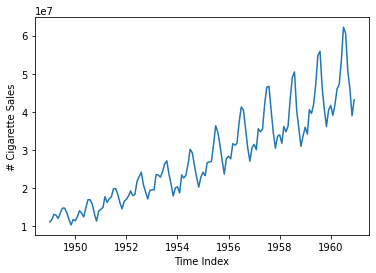

In [23]:
plt.plot(y)
plt.xlabel('Time Index')
plt.ylabel('# Cigarette Sales')
plt.show()

## 3. Modelling 
### 3a. Decomposition
What do you notice from the plot? Take at least `2` minutes to examine the plot, and write down everything you observe.  

**Plot shows increasing trend. Upward and downward are consistently repeating over the whole timeline. However, the depth of each interval is gradually increasing. Therefore, the trend is increasing.**


All done?

We can see that, generally, there is a trend upwards in cigarette sales from at Cowboy Cigarettes. But there are also some striking - and perhaps unexpected - seasonal fluctuations. These seasonal fluctations come in a repeated pattern. Work out when these seasonal fluctuations are happening, and take 2 minutes to hypothesize on their cause here.

**There are total of 12 intervals. When we calculate 'total months / the number of interval = 144/12', it's 12. With this result, I can assume that an interval happened every single year.**

What does it mean to *decompose* time series data? It means breaking that data into 3 components: 

1. **Trend**: The overall direction that the data is travelling in (like upwards or downwards)
2. **Seasonality**: Cyclical patterns in the data 
3. **Noise**: The random variation in the data

We can treat these components differently, depending on the question and what's appropriate in the context. They can either be added together in an *additive* model, or multiplied together in a *multiplicative* model. 

Make a coffee, take `5` minutes and read [this article](https://medium.com/@sigmundojr/seasonality-in-python-additive-or-multiplicative-model-d4b9cf1f48a7) and think about whether our data would conduce to an additive or multiplicative model here. Write your conclusion down just here: 

**Our data is a multiplicative mode because it has an increasing amplitude over time. If it's an additive model, the seasonality has the same amplitude and frequency.**

All done? Well, just on the basis of the plot above, it seems our Cowboy Cigarettes data is actually multiplicative. 

That's because, as time progresses, the general trend seems to be increasing *at a rate that's also increasing*. We also see that the seasonal fluctuations (the peaks and troughs) get bigger and bigger as time progresses.

Now on the other hand, if the data were simply additive, we could expect the general trend to increase at a *steadily*, and a constant speed; and also for seasonal ups and downs not to increase or decrease in extent over time.

Happily, we can use the `decompose()` function to quantify the component parts described above in our data.

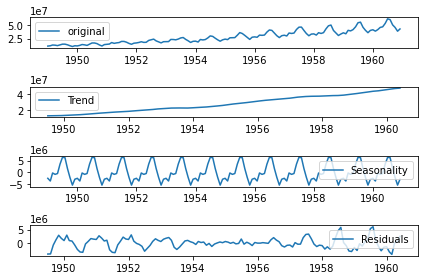

In [24]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Make a variable called decomposition, and assign it y passed to seasonal_decompose() 
decomposition = seasonal_decompose(y)

# Make three variables for trend, seasonal and residual components respectively. 
# Assign them the relevant features of decomposition 
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid


# Plot the original data, the trend, the seasonality, and the residuals 
plt.subplot(411)
plt.plot(y, label = 'original')
plt.legend(loc = 'best')
plt.subplot(412)
plt.plot(trend, label = 'Trend')
plt.legend(loc = 'best')
plt.subplot(413)
plt.plot(seasonal, label = 'Seasonality')
plt.legend(loc = 'best')
plt.subplot(414)
plt.plot(residual, label = 'Residuals')
plt.legend(loc = 'best')
plt.tight_layout()

### 3b. Testing for stationarity with KPSS
As you know, when doing time series analysis we always have to check for stationarity. Imprecisely, a time series dataset is stationary just if its statistical features don't change over time. A little more precisely, a stationary time series dataset will have constant mean, variance, and covariance.

There are many ways to test for stationarity, but one of the most common is the KPSS test. The Null hypothesis of this test is that the time series data in question is stationary; hence, if the *p*-value is less than the significance level (typically 0.05, but we decide) then we reject the Null and infer that the data is not stationary.

In [25]:
from statsmodels.tsa.stattools import kpss
kpss(y)

/Users/hansangjun/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


(1.6513122354165233,
 0.01,
 8,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

Since our p-value is less than 0.05, we should reject the Null hypothesis and deduce the non-stationarity of our data. 

But our data need to be stationary! So we need to do some transforming.

### 3c. Making the data stationary 
Let's recall what it looks like. 

<AxesSubplot:xlabel='Month'>

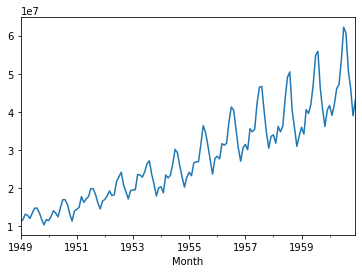

In [26]:
y.plot()

In our plot, we can see that both the mean and the variance *increase as time progresses*. At the moment, our data has neither a constant mean, nor a constant variance (the covariance, however, seems constant). 

One often  used way of getting rid of changing variance is to take the natural log of all the values in our dataset. Let's do this now. 

In [27]:
y_log = np.log(y)


When you plot this, you can see how the variance in our data now remains contant over time.

<AxesSubplot:xlabel='Month'>

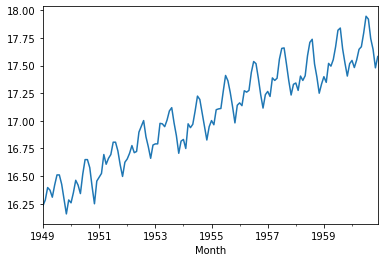

In [28]:
y_log.plot()

We now have a constant variance, but we also need a constant mean.

We can do this by *differencing* our data. We difference a time series dataset when we create a new time series comprising the difference between the values of our existing dataset.

Python is powerful, and we can use the `diff()` function to do this. You'll notice there's one less value than our existing dataset (since we're taking the difference between the existing values).

In [29]:
kpss(y_log.diff().dropna())

/Users/hansangjun/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


(0.03830446954674065,
 0.1,
 6,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

Our p-value is now greater than 0.05, so we can accept the null hypothesis that our data is stationary.

### 3d. The ARIMA model

Recall that ARIMA models are based around the idea that it's possible to predict the next value in a time series by using information about the most recent data points. It also assumes there will be some randomness in our data that can't ever be predicted.

We can find some good parameters for our model using the `sklearn` and `statsmodels` libraries, and in particular `mean_squared_error` and `ARIMA`. 

In [30]:
# Import mean_squared_error and ARIMA
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima_model import ARIMA

#### 3di. Make a function to find the MSE of a single ARIMA model
Things get intricate here. Don't worry if you can't do this yourself and need to drop down a Tier. 

In [52]:
def get_mse(data, order=(0,0,0), seasonal_order=(0,0,0,0)):
    """
    Creates a 'Seasonal AR Integrated Moving Average w/ eXogenous factors'
    ('SARIMAX') model.
    
    Creates a Train-Test split, fits the data, forecasts the data over the 
    validation period, then compares the forecasted data with the actual data
    """
    
    # Train-Test split. Validation is 24 months in prep to forecast 24 months out
    X = data.iloc[:len(data)-24]
    y = data.drop(X.index)
      
    # define and fit the model
    model = SARIMAX(X, order=order, seasonal_order=seasonal_order)
    model_fit = model.fit()
    
    # predict the future!
    pred = model_fit.forecast(len(y))
    
    # return the MSE on our prediction
    return mean_squared_error(y, pred)

#### 3dii. Make a function to evaluate the different ARIMA models with different p, d, and q values

In [32]:
# Make a function called evaluate_models to evaluate different ARIMA models with several different p, d, and q values.
def evaluate_models(dataset, p_values, d_values, q_values):
    best_score, best_cfg = float("inf"), None
    # Iterate through p_values
    for p in p_values:
        # Iterate through d_values
        for d in d_values:
            # Iterate through q_values
            for q in q_values:
                # p, d, q iterator variables in that order
                order = (p,d,q)
                try:
                    # Make a variable called mse for the Mean squared error
                    mse = evaluate_arima_model(dataset, order)
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                    print('ARIMA%s MSE=%.3f' % (order,mse))
                except:
                    continue
    return print('Best ARIMA%s MSE=%.3f' % (best_cfg, best_score))

I am going to use the SARIMAX, not the ARIMA because the data is obviously seasonal.

In [43]:
# Difference the data with period 12, corresponding to 12 months 
dfdiff = y_log.diff(12)

# remove the first 12 records as they are now filled with NaNs
dfdiff = dfdiff.iloc[12:]

dfdiff.info()

<class 'pandas.core.series.Series'>
DatetimeIndex: 132 entries, 1950-01-01 to 1960-12-01
Series name: #CigSales
Non-Null Count  Dtype  
--------------  -----  
132 non-null    float64
dtypes: float64(1)
memory usage: 2.1 KB


In [44]:
from pmdarima import auto_arima # for determining ARIMA orders

# Perform a train-test-split with validation period of 24 months
# The rule of thumb when forecasting is that the validation length should
# be at least the same size as the projected forecast length

X = y_log.iloc[:len(dfdiff)-24]
y = y_log.drop(X.index)

# Perform the 'auto_arima' grid search to find the best paramaters for our model
auto_arima(X, m=12).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  108
Model:             SARIMAX(2, 0, 0)x(2, 1, 0, 12)   Log Likelihood                 179.890
Date:                            Fri, 21 Oct 2022   AIC                           -347.780
Time:                                    23:45:22   BIC                           -332.394
Sample:                                01-01-1949   HQIC                          -341.560
                                     - 12-01-1957                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0561      0.026      2.167      0.030       0.005       0.107
ar.L1          0.5617      0.105      5.352      0.000       0.356       0.767
ar.L2          0.2075      0.100      2.085      0.037       0.012       0.403
ar.S.L12      -0.5635      0.118     -4.761      0.000      -0.796      -0.332
ar.S.L24      -0.2666      0.141     -1.891      0.059      -0.543       0.010
sigma2         0.0013      0.000      6.953      0.000       0.001       0.002
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                 7.59
Prob(Q):                              0.90   Prob(JB):                         0.02
Heteroskedasticity (H):               0.28   Skew:                             0.15
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.34
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

p=2, d=0, q=0, ps=0, pd=1, pq=1, period=12

In [53]:
# test 
import warnings
from statsmodels.tsa.statespace.sarimax import SARIMAX
warnings.filterwarnings("ignore")

# Test our get_mse() function
get_mse(y_log, (0,1,1))


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -8.44053D-01    |proj g|=  2.56712D-01

At iterate    5    f= -8.44888D-01    |proj g|=  2.71761D-01

At iterate   10    f= -8.45372D-01    |proj g|=  8.14009D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     11     16      1     0     0   6.343D-05  -8.454D-01
  F = -0.84537157442121069     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


0.08785507368760952

In [54]:
# Make a function to evaluate different SARIMAX models with different p, d, and q values.
# As well as different Seasonal p, d, and q values.  It then compares the MSEs
# for all models and returns the model parameters for the lowest Error model.

def get_pdq (data):
    i = 0
    mses = pd.DataFrame()  # holds model parameters and MSEs
    
    # nested loop through all parameters.  this loop could be optimized but
    # is left as-is because it's easier to understand.
    for p in range(0,2):
        for d in range(0,2):
            for q in range (0,3):
                for ps in range(0,2):
                    for ds in range(0,2):
                        for qs in range(0,2):
                            # build/fit/predict model and get the MSE
                            mse = get_mse(data, order=(p,d,q), 
                                          seasonal_order=(ps,ds,qs,12))
                            
                            # save the parameters and MSE
                            mses = mses.append(
                                pd.DataFrame({'p':p, 
                                              'd':d, 
                                              'q':q,
                                              'ps':ps,
                                              'ds':ds,
                                              'qs':qs,
                                              'mse':mse}, index=[i]))
                            i = i+1
             
    # sort our collection by MSE and return the parameters with the lowest MSE
    mses = mses.sort_values(by='mse', axis=0, ascending=True).reset_index()
    return mses.iloc[0]

In [58]:
# Finally, we can find an optimum SARIMAX model for our data.
# Nb. this can take a while...!

# Get the optimal parameters for our model
pdq = get_pdq(y_log)

print('mse: '.ljust(6), pdq.mse)
print()
print('p:'.ljust(6), int(pdq.p))
print('d:'.ljust(6), int(pdq.d))
print('q:'.ljust(6), int(pdq.q))
print('ps:'.ljust(6), int(pdq.ps))
print('ds:'.ljust(6), int(pdq.ds))
print('qs:'.ljust(6), int(pdq.qs))
print('s:'.ljust(6), 12)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.24907D+00    |proj g|=  3.47278D-08

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      0      1      0     0     0   3.473D-08   4.249D+00
  F =   4.2490746640683117     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.2

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f=  1.59151D+00    |proj g|=  3.02765D-01

At iterate   20    f=  4.25805D-01    |proj g|=  2.92288D-01

At iterate   25    f=  2.04350D-02    |proj g|=  4.02435D+00

At iterate   30    f= -2.82400D-02    |proj g|=  5.39473D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     33     75      1     0     0   1.750D-03  -2.824D-02
  F =  -2.8240349660199400E-002

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iter


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   20    f=  2.06616D-01    |proj g|=  1.83147D+00

At iterate   25    f= -5.03049D-02    |proj g|=  4.00527D-01
  ys=-1.963E-04  -gs= 2.881E-05 BFGS update SKIPPED

At iterate   30    f= -6.81321D-02    |proj g|=  4.11343D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     32     83      2     1     0   1.634D-03  -6.813D-02
  F =  -6.8132143848892157E-002

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0  


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   10    f= -8.29865D-01    |proj g|=  1.40412D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     12     26      1     0     0   1.163D-04  -8.299D-01
  F = -0.82986543887713082     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.46811D-01    |proj g|=  9.65425D+00

At iterate    5    f= -7.51425D-01    |proj g|=  2.90890D+00

At iterate   10    f= -8.74704D-01    |proj g|=  4.90618D-02

At iter

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  3.64974D+00    |proj g|=  3.73905D-02

At iterate   10    f=  3.58243D+00    |proj g|=  1.56752D-03

At iterate   15    f=  3.58030D+00    |proj g|=  7.14911D-04

At iterate   20    f=  3.58005D+00    |proj g|=  1.03060D-04

At iterate   25    f=  3.58003D+00    |proj g|=  6.24079D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     25     28      1     0     0   6.241D-06   3.580D+00
  F =   3.5800269994404128     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f= -9.53405D-01    |proj g|=  2.30895D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     12     21      1     0     0   1.163D-04  -9.534D-01
  F = -0.95340481030989865     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.51932D+00    |proj g|=  1.78670D+00

At iterate    5    f=  1.35313D+00    |proj g|=  5.96193D+00

At iterate   10    f=  6.66847D-01    |proj g|=  1.49315D+00

At iter

 This problem is unconstrained.



At iterate   25    f= -4.11523D-01    |proj g|=  7.57080D-01

At iterate   30    f= -4.15143D-01    |proj g|=  2.71116D-02

At iterate   35    f= -4.15329D-01    |proj g|=  1.13519D-02

At iterate   40    f= -4.15411D-01    |proj g|=  1.18520D-01

At iterate   45    f= -4.15611D-01    |proj g|=  3.11459D-03

At iterate   50    f= -4.15612D-01    |proj g|=  2.83322D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     50     88      1     0     0   2.833D-03  -4.156D-01
  F = -0.41561200979449092     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.



At iterate    5    f=  3.11353D+00    |proj g|=  3.60258D-01

At iterate   10    f=  9.97270D-01    |proj g|=  1.31378D+00

At iterate   15    f=  2.83129D-01    |proj g|=  2.74331D+00

At iterate   20    f= -2.57367D-01    |proj g|=  1.34204D-01

At iterate   25    f= -4.29872D-01    |proj g|=  1.05987D+00

At iterate   30    f= -4.37789D-01    |proj g|=  1.70594D-03

At iterate   35    f= -4.37789D-01    |proj g|=  1.85537D-03

At iterate   40    f= -4.37796D-01    |proj g|=  2.40459D-02

At iterate   45    f= -4.39053D-01    |proj g|=  2.80690D-02

At iterate   50    f= -4.47046D-01    |proj g|=  1.48039D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f= -1.02224D+00    |proj g|=  4.17126D-01

At iterate   15    f= -1.02693D+00    |proj g|=  2.46187D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     17     25      1     0     0   5.255D-04  -1.027D+00
  F =  -1.0269290709897225     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -7.99361D-01    |proj g|=  4.29862D+00

At iterate    5    f= -1.01647D+00    |proj g|=  2.07472D+00

At iter

 This problem is unconstrained.
 This problem is unconstrained.


At iterate    5    f=  2.94579D+00    |proj g|=  3.64406D-02

At iterate   10    f=  2.93498D+00    |proj g|=  1.15118D-02

At iterate   15    f=  2.93396D+00    |proj g|=  6.73659D-04

At iterate   20    f=  2.93338D+00    |proj g|=  5.38076D-04

At iterate   25    f=  2.93331D+00    |proj g|=  1.94662D-04

At iterate   30    f=  2.93330D+00    |proj g|=  9.25127D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     30     41      1     0     0   9.251D-06   2.933D+00
  F =   2.9332997117533011     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine

 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     17     29      1     0     0   1.950D-03  -1.141D+00
  F =  -1.1405806065420208     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -8.54265D-01    |proj g|=  5.07717D+00

At iterate    5    f= -1.16994D+00    |proj g|=  2.71466D-01

At iterate   10    f= -1.18659D+00    |proj g|=  8.28813D-02

At iterate   15    f= -1.18689D+00    |proj g|=  9.29119D-03

At iter

 This problem is unconstrained.



At iterate   25    f= -4.02025D-01    |proj g|=  3.77855D-01

At iterate   30    f= -4.05077D-01    |proj g|=  1.00330D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     32     89      1     0     0   4.118D-03  -4.051D-01
  F = -0.40507740101401929     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.76510D+00    |proj g|=  2.14366D+00

At iterate    5    f=  1.47344D+00    |proj g|=  4.23589D-01



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   10    f=  1.13417D+00    |proj g|=  6.38113D-02

At iterate   15    f=  1.08436D+00    |proj g|=  8.33040D-03

At iterate   20    f=  2.00000D-01    |proj g|=  1.27050D+00

At iterate   25    f= -1.58669D-01    |proj g|=  1.59098D+00

At iterate   30    f= -3.35698D-01    |proj g|=  8.05601D-01

At iterate   35    f= -4.20263D-01    |proj g|=  1.80185D-02

At iterate   40    f= -4.20479D-01    |proj g|=  7.13738D-04



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.



At iterate   45    f= -4.20506D-01    |proj g|=  2.01694D-02

At iterate   50    f= -4.20639D-01    |proj g|=  3.59054D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50    131      2     0     0   3.591D-02  -4.206D-01
  F = -0.42063923420379962     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -8.20615D-01    |proj g|=  5.09323D+00

At iterate    5    f= -1.14015D+00    |proj g|=  4.43762D-01

At iter


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.



At iterate    5    f= -1.25881D+00    |proj g|=  6.12085D-01

At iterate   10    f= -1.26264D+00    |proj g|=  9.93357D-01

At iterate   15    f= -1.27360D+00    |proj g|=  4.31858D-02

At iterate   20    f= -1.27495D+00    |proj g|=  4.89954D-01

At iterate   25    f= -1.28907D+00    |proj g|=  1.49859D+00

At iterate   30    f= -1.32085D+00    |proj g|=  1.21641D-02

At iterate   35    f= -1.32392D+00    |proj g|=  2.14672D-02

At iterate   40    f= -1.32519D+00    |proj g|=  2.55415D-01

At iterate   45    f= -1.32678D+00    |proj g|=  6.08955D-02

At iterate   50    f= -1.32699D+00    |proj g|=  6.00332D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f= -1.58668D+00    |proj g|=  2.06051D+00

At iterate   10    f= -1.59995D+00    |proj g|=  2.86727D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     13     27      1     0     0   4.476D-04  -1.600D+00
  F =  -1.5999551124823062     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.58155D+00    |proj g|=  1.01949D+00

At iterate    5    f= -1.58352D+00    |proj g|=  1.16430D+00

At iter

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f= -1.65909D+00    |proj g|=  7.93178D-02

At iterate   15    f= -1.65913D+00    |proj g|=  2.53596D-01

At iterate   20    f= -1.66409D+00    |proj g|=  4.95394D+00

At iterate   25    f= -1.68631D+00    |proj g|=  5.01697D-01

At iterate   30    f= -1.68771D+00    |proj g|=  1.25814D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     33     44      1     0     0   1.964D-03  -1.688D+00
  F =  -1.6877058438859041     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.55263D+00    |proj g|=  8.23438D+00

At iterate    5    f= -1.57391D+00    |proj g|=  7.75348D-01

At iterate   10    f= -1.58589D+00    |proj g|=  6.37597D-02

At iterate   15    f= -1.58873D+00    |proj g|=  4.96873D-01

At iterate   20    f= -1.59996D+00    |proj g|=  7.44071D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     22     30      1     0     0   4.338D-03  -1.600D+00
  F =  -1.5999756737053465     

CONVERG

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.02902D+00    |proj g|=  3.96505D+00

At iterate    5    f= -1.10617D+00    |proj g|=  2.07335D+00

At iterate   10    f= -1.16668D+00    |proj g|=  5.36931D-02

At iterate   15    f= -1.16754D+00    |proj g|=  6.40098D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     15     20      1     0     0   6.401D-05  -1.168D+00
  F =  -1.1675355223245905     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING 


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f= -1.68364D+00    |proj g|=  1.21785D-01

At iterate   15    f= -1.68647D+00    |proj g|=  1.32975D+00

At iterate   20    f= -1.68943D+00    |proj g|=  3.98540D-03

At iterate   25    f= -1.68962D+00    |proj g|=  1.65092D-01

At iterate   30    f= -1.69818D+00    |proj g|=  5.21030D+00

At iterate   35    f= -1.71883D+00    |proj g|=  8.69215D-02

At iterate   40    f= -1.72259D+00    |proj g|=  5.42720D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     42     69      1     0     0   1.809D-03  -1.723D+00
  F =  -1.7225920217864918     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f= -1.63718D+00    |proj g|=  1.58406D+00

At iterate   10    f= -1.64117D+00    |proj g|=  9.74413D-02

At iterate   15    f= -1.64374D+00    |proj g|=  7.24973D-01

At iterate   20    f= -1.64507D+00    |proj g|=  3.98516D-01

At iterate   25    f= -1.64675D+00    |proj g|=  4.61214D-02

At iterate   30    f= -1.64675D+00    |proj g|=  7.42505D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     34     50      1     0     0   2.730D-03  -1.647D+00
  F =  -1.6467504012374712     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f= -1.12556D+00    |proj g|=  2.75680D+00

At iterate   10    f= -1.16825D+00    |proj g|=  3.98700D-02

At iterate   15    f= -1.16943D+00    |proj g|=  1.41515D-02

At iterate   20    f= -1.16946D+00    |proj g|=  4.25169D-02

At iterate   25    f= -1.16946D+00    |proj g|=  1.54242D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     27     34      1     0     0   7.033D-05  -1.169D+00
  F =  -1.1694643140626053     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.



At iterate   20    f= -1.53509D+00    |proj g|=  4.61031D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     20     54      2     0     0   4.610D-03  -1.535D+00
  F =  -1.5350853684478305     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.61503D+00    |proj g|=  4.67455D+00

At iterate    5    f= -1.64149D+00    |proj g|=  1.70791D+00

At iterate   10    f= -1.64469D+00    |proj g|=  5.84612D-01

At iter


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     21     78      2     0     0   5.003D-04  -1.646D+00
  F =  -1.6461058382392522     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.10900D+00    |proj g|=  7.27198D+00

At iterate    5    f= -1.48638D+00    |proj g|=  5.84762D+00

At iterate   10    f= -1.61470D+00    |proj g|=  9.09758D-02

At iterate   15    f= -1.61604D+00    |proj g|=  1.22111D+00

At iter

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.01077D+00    |proj g|=  7.85369D+00

At iterate    5    f= -1.67219D+00    |proj g|=  4.23296D+00

At iterate   10    f= -1.68850D+00    |proj g|=  6.29753D-02

At iterate   15    f= -1.68981D+00    |proj g|=  1.23684D-02

At iterate   20    f= -1.69004D+00    |proj g|=  3.39004D-01

At iterate   25    f= -1.70674D+00    |proj g|=  2.27545D+00

At iterate   30    f= -1.71976D+00    |proj g|=  6.84720D-01

At iterate   35    f= -1.72325D+00    |proj g|=  2.79477D-02

At iterate   40    f= -1.72325D+00    |proj g|=  5.09375D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

 This problem is unconstrained.


At iterate    5    f= -1.62247D+00    |proj g|=  2.43866D-01

At iterate   10    f= -1.62558D+00    |proj g|=  2.84451D-01

At iterate   15    f= -1.62571D+00    |proj g|=  9.11269D-02

At iterate   20    f= -1.62604D+00    |proj g|=  5.97950D-04



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     21     66      2     0     0   5.980D-04  -1.626D+00
  F =  -1.6260435099045736     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.61214D+00    |proj g|=  4.51031D+00

At iterate    5    f= -1.62661D+00    |proj g|=  9.85260D-01

At iterate   10    f= -1.64112D+00    |proj g|=  1.37753D-01

At iterate   15    f= -1.64177D+00    |proj g|=  1.54249D-01

At iter

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.29166D+04    |proj g|=  2.44986D+05

At iterate    5    f=  8.14321D+00    |proj g|=  1.72215D+01

At iterate   10    f=  1.92940D+00    |proj g|=  6.82741D-01

At iterate   15    f=  2.94262D-01    |proj g|=  3.36722D-01

At iterate   20    f= -7.50466D-01    |proj g|=  1.40335D+00

At iterate   25    f= -1.04857D+00    |proj g|=  9.61260D-01

At iterate   30    f= -1.10544D+00    |proj g|=  9.53599D-02

At iterate   35    f= -1.10894D+00    |proj g|=  8.82098D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   20    f= -1.58870D+00    |proj g|=  1.70789D+00

At iterate   25    f= -1.60840D+00    |proj g|=  4.15742D-01

At iterate   30    f= -1.60886D+00    |proj g|=  1.24537D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     34     47      1     0     0   2.701D-02  -1.609D+00
  F =  -1.6089140718222044     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.29166D+04    |proj g|=  2.44986D+05

At iter

 This problem is unconstrained.
 This problem is unconstrained.


At iterate   15    f= -6.19253D-01    |proj g|=  5.55959D+00

At iterate   20    f= -1.45216D+00    |proj g|=  3.47917D+00

At iterate   25    f= -1.49485D+00    |proj g|=  1.17857D-02

At iterate   30    f= -1.52655D+00    |proj g|=  2.00337D+00

At iterate   35    f= -1.54519D+00    |proj g|=  8.44779D-01

At iterate   40    f= -1.55063D+00    |proj g|=  1.53049D-02

At iterate   45    f= -1.55075D+00    |proj g|=  1.08284D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     46     73      1     1     0   7.249D-07  -1.551D+00
  F =  -1.5507520642551347     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL   

 This problem is unconstrained.



At iterate   10    f= -1.49739D+00    |proj g|=  7.11300D+00

At iterate   15    f= -1.57015D+00    |proj g|=  3.91803D-02

At iterate   20    f= -1.57585D+00    |proj g|=  2.76748D-02

At iterate   25    f= -1.57832D+00    |proj g|=  3.50835D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     28     47      1     0     0   4.552D-04  -1.578D+00
  F =  -1.5783210305042243     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.



At iterate    5    f= -1.54692D+00    |proj g|=  2.17152D+00

At iterate   10    f= -1.55046D+00    |proj g|=  1.49237D-01

At iterate   15    f= -1.55410D+00    |proj g|=  2.25519D+00

At iterate   20    f= -1.59443D+00    |proj g|=  3.24597D+00

At iterate   25    f= -1.60185D+00    |proj g|=  7.89715D-03

At iterate   30    f= -1.60211D+00    |proj g|=  4.57466D-02

At iterate   35    f= -1.60871D+00    |proj g|=  2.21996D-01

At iterate   40    f= -1.60892D+00    |proj g|=  1.05878D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     44     70      1     0     0   4.971D-03  -1.609D+00
  F =  -1.60892462253

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f= -4.22532D-01    |proj g|=  8.44368D-01

At iterate   20    f= -4.66975D-01    |proj g|=  7.24594D-01

At iterate   25    f= -6.63082D-01    |proj g|=  2.74664D-02

At iterate   30    f= -7.93535D-01    |proj g|=  1.80948D-01

At iterate   35    f= -8.08999D-01    |proj g|=  7.50161D-03

At iterate   40    f= -8.10041D-01    |proj g|=  3.19481D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     42     67      1     0     0   7.703D-07  -8.100D-01
  F = -0.81004075085750249     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f= -1.54795D+00    |proj g|=  3.77743D-01

At iterate   10    f= -1.54843D+00    |proj g|=  2.83599D-03

At iterate   15    f= -1.54843D+00    |proj g|=  5.32365D-04

At iterate   20    f= -1.54843D+00    |proj g|=  1.31091D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     21     32      1     0     0   2.096D-03  -1.548D+00
  F =  -1.5484278516689156     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.



At iterate   20    f= -1.18339D+00    |proj g|=  2.47575D+00

At iterate   25    f= -1.50222D+00    |proj g|=  5.89590D-02

At iterate   30    f= -1.53512D+00    |proj g|=  9.73042D-01

At iterate   35    f= -1.53814D+00    |proj g|=  7.51297D-03

At iterate   40    f= -1.53873D+00    |proj g|=  9.00667D-01

At iterate   45    f= -1.55632D+00    |proj g|=  5.97401D+00

At iterate   50    f= -1.56998D+00    |proj g|=  2.53366D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     50     69      1     0     0   2.534D-01  -1.570D+00
  F =  -1.5699802927425557     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT       

 This problem is unconstrained.



At iterate    5    f=  7.58629D+00    |proj g|=  1.61935D+01

At iterate   10    f=  1.66182D+00    |proj g|=  6.16311D-01
  ys=-1.762E+00  -gs= 9.331E-01 BFGS update SKIPPED

At iterate   15    f= -4.93471D-01    |proj g|=  2.86353D-01

At iterate   20    f= -9.72684D-01    |proj g|=  6.50597D+00

At iterate   25    f= -1.41897D+00    |proj g|=  1.64699D+00

At iterate   30    f= -1.52952D+00    |proj g|=  2.57563D+00

At iterate   35    f= -1.60910D+00    |proj g|=  2.78027D+00

At iterate   40    f= -1.68259D+00    |proj g|=  1.04325D-01

At iterate   45    f= -1.68516D+00    |proj g|=  1.86138D-02

At iterate   50    f= -1.68516D+00    |proj g|=  5.21705D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final 

 This problem is unconstrained.



At iterate   35    f= -1.63609D+00    |proj g|=  1.79436D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     38     64      1     0     0   3.715D-02  -1.636D+00
  F =  -1.6360900419514632     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.49915D+00    |proj g|=  1.19164D+00

At iterate    5    f= -1.59537D+00    |proj g|=  3.92376D-01

At iterate   10    f= -1.59631D+00    |proj g|=  9.12284D-01


 This problem is unconstrained.



At iterate   15    f= -1.60800D+00    |proj g|=  1.36963D+00

At iterate   20    f= -1.60947D+00    |proj g|=  1.18325D-01

At iterate   25    f= -1.62055D+00    |proj g|=  2.66229D+00

At iterate   30    f= -1.64629D+00    |proj g|=  1.69386D-01

At iterate   35    f= -1.64686D+00    |proj g|=  2.49977D-01

At iterate   40    f= -1.65465D+00    |proj g|=  1.77436D-01

At iterate   45    f= -1.65518D+00    |proj g|=  2.17185D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     49     84      1     0     0   1.401D-01  -1.655D+00
  F =  -1.6552646465414436     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  7.19197D+00    |proj g|=  1.51650D+01

At iterate   10    f=  1.76089D+00    |proj g|=  6.01869D-01

At iterate   15    f=  1.04520D-01    |proj g|=  2.74519D-01

At iterate   20    f= -2.12232D-01    |proj g|=  2.60384D-01

At iterate   25    f= -7.49256D-01    |proj g|=  1.31166D+00

At iterate   30    f= -7.92975D-01    |proj g|=  1.39498D+00

At iterate   35    f= -8.10069D-01    |proj g|=  3.05852D-01

At iterate   40    f= -8.25825D-01    |proj g|=  2.65881D-01

At iterate   45    f= -8.27786D-01    |proj g|=  2.20071D-02

At iterate   50    f= -8.27827D-01    |proj g|=  7.52539D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f= -1.54552D+00    |proj g|=  8.95640D-01

At iterate   10    f= -1.54833D+00    |proj g|=  7.63312D-02

At iterate   15    f= -1.54855D+00    |proj g|=  2.45565D-01

At iterate   20    f= -1.54858D+00    |proj g|=  1.03716D-03

At iterate   25    f= -1.54863D+00    |proj g|=  4.03712D-02

At iterate   30    f= -1.54866D+00    |proj g|=  7.84969D-03

At iterate   35    f= -1.54866D+00    |proj g|=  3.15056D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     39     58      1     0     0   1.450D-02  -1.549D+00
  F =  -1.5486607905597503     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate    5    f= -1.46540D+00    |proj g|=  4.07632D+00

At iterate   10    f= -1.62713D+00    |proj g|=  7.10242D-01

At iterate   15    f= -1.62800D+00    |proj g|=  8.53917D-01

At iterate   20    f= -1.63658D+00    |proj g|=  4.05834D-01

At iterate   25    f= -1.63737D+00    |proj g|=  4.52350D-01

At iterate   30    f= -1.63773D+00    |proj g|=  2.40251D-02

At iterate   35    f= -1.63998D+00    |proj g|=  2.43055D-01

At iterate   40    f= -1.65256D+00    |proj g|=  1.66822D-01

At iterate   45    f= -1.65448D+00    |proj g|=  1.71448D-02

At iterate   50    f= -1.65450D+00    |proj g|=  1.17482D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate   25    f= -1.42006D+00    |proj g|=  2.42915D-01

At iterate   30    f= -1.52535D+00    |proj g|=  8.03767D-01

At iterate   35    f= -1.53452D+00    |proj g|=  3.10759D-01

At iterate   40    f= -1.53532D+00    |proj g|=  1.44276D-02

At iterate   45    f= -1.53849D+00    |proj g|=  6.88385D-02

At iterate   50    f= -1.57595D+00    |proj g|=  1.00726D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     72      1     0     0   1.007D-01  -1.576D+00
  F =  -1.5759493035463303     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.



At iterate   10    f=  1.65487D+00    |proj g|=  7.35938D-01
  ys=-1.177E+00  -gs= 1.027E+00 BFGS update SKIPPED

At iterate   15    f= -4.80885D-01    |proj g|=  8.32753D-01

At iterate   20    f= -9.65889D-01    |proj g|=  7.18659D-01

At iterate   25    f= -1.16012D+00    |proj g|=  1.73684D+00

At iterate   30    f= -1.53261D+00    |proj g|=  8.88245D-01

At iterate   35    f= -1.64853D+00    |proj g|=  1.76966D+00

At iterate   40    f= -1.68402D+00    |proj g|=  7.09410D-02

At iterate   45    f= -1.68444D+00    |proj g|=  8.40205D-02

At iterate   50    f= -1.68448D+00    |proj g|=  1.99057D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  

 This problem is unconstrained.



At iterate   10    f= -1.44694D+00    |proj g|=  1.57742D+00

At iterate   15    f= -1.62456D+00    |proj g|=  1.68073D+00

At iterate   20    f= -1.62848D+00    |proj g|=  1.14619D-02

At iterate   25    f= -1.63013D+00    |proj g|=  3.51353D-02

At iterate   30    f= -1.63563D+00    |proj g|=  6.91892D-02

At iterate   35    f= -1.63610D+00    |proj g|=  2.76123D-02

At iterate   40    f= -1.63613D+00    |proj g|=  2.69176D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     42     64      1     0     0   1.227D-02  -1.636D+00
  F =  -1.6361285279518321     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate    5    f= -1.57982D+00    |proj g|=  6.83645D-01

At iterate   10    f= -1.58226D+00    |proj g|=  1.35461D+00

At iterate   15    f= -1.60173D+00    |proj g|=  7.25933D-01

At iterate   20    f= -1.60719D+00    |proj g|=  8.72806D-01

At iterate   25    f= -1.61065D+00    |proj g|=  9.41758D-01

At iterate   30    f= -1.63253D+00    |proj g|=  9.24141D-01

At iterate   35    f= -1.64334D+00    |proj g|=  3.50387D-01

At iterate   40    f= -1.64381D+00    |proj g|=  9.53337D-02

At iterate   45    f= -1.64743D+00    |proj g|=  3.72752D-02

At iterate   50    f= -1.65430D+00    |proj g|=  3.19501D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -8.38257D-01    |proj g|=  6.15286D-02

At iterate    5    f= -8.38267D-01    |proj g|=  6.72620D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      9     13      1     0     0   2.515D-05  -8.383D-01
  F = -0.83826750058601429     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 v

 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      2      6      1     0     0   3.573D-03  -1.532D+00
  F =  -1.5315541351121957     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.61816D+00    |proj g|=  4.38746D+00


 This problem is unconstrained.



At iterate    5    f= -1.64388D+00    |proj g|=  4.78389D-01

At iterate   10    f= -1.64431D+00    |proj g|=  1.34006D-01

At iterate   15    f= -1.64435D+00    |proj g|=  1.25750D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     19     34      1     0     0   3.475D-03  -1.644D+00
  F =  -1.6443465358076572     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.12787D+00    |proj g|=  7.55186D+00

At iter

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f= -1.61956D+00    |proj g|=  1.29652D+00

At iterate   15    f= -1.62080D+00    |proj g|=  2.76297D-03

At iterate   20    f= -1.62080D+00    |proj g|=  3.77552D-02

At iterate   25    f= -1.62081D+00    |proj g|=  1.75160D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     26     39      1     0     0   1.462D-03  -1.621D+00
  F =  -1.6208128411592344     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.61126D+00    |proj g|=  4.18988D+00

At iterate    5    f= -1.62204D+00    |proj g|=  1.56670D-02

At iterate   10    f= -1.62214D+00    |proj g|=  4.06493D-01

At iterate   15    f= -1.62233D+00    |proj g|=  9.88672D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     16     30      1     0     0   9.887D-03  -1.622D+00
  F =  -1.6223267091626958     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING 

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f= -8.46595D-01    |proj g|=  2.20700D-01

At iterate   10    f= -8.47340D-01    |proj g|=  8.08624D-02

At iterate   15    f= -8.50610D-01    |proj g|=  9.56418D-01

At iterate   20    f= -8.64691D-01    |proj g|=  2.69946D-01

At iterate   25    f= -8.65332D-01    |proj g|=  5.95057D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     25     30      1     0     0   5.951D-05  -8.653D-01
  F = -0.86533175269382712     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

 This problem is unconstrained.
 This problem is unconstrained.


Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.61602D+00    |proj g|=  4.71614D+00

At iterate    5    f= -1.63111D+00    |proj g|=  7.89927D-01

At iterate   10    f= -1.64435D+00    |proj g|=  3.82542D-01

At iterate   15    f= -1.64446D+00    |proj g|=  4.09479D-02

At iterate   20    f= -1.64447D+00    |proj g|=  5.11589D-03

At iterate   25    f= -1.64484D+00    |proj g|=  1.15256D-01

At iterate   30    f= -1.64698D+00    |proj g|=  1.24393D-01

At iterate   35    f= -1.64700D+00    |proj g|=  1.12181D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf 

 This problem is unconstrained.



At iterate    5    f= -1.52240D+00    |proj g|=  5.16887D+00

At iterate   10    f= -1.62086D+00    |proj g|=  5.65661D-02

At iterate   15    f= -1.62087D+00    |proj g|=  1.38967D-02

At iterate   20    f= -1.62089D+00    |proj g|=  1.93358D-01

At iterate   25    f= -1.62116D+00    |proj g|=  2.41898D-01

At iterate   30    f= -1.62120D+00    |proj g|=  3.83687D-02

At iterate   35    f= -1.62130D+00    |proj g|=  5.02887D-02

At iterate   40    f= -1.62177D+00    |proj g|=  4.91582D-01

At iterate   45    f= -1.62196D+00    |proj g|=  2.29599D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     47     63   

 This problem is unconstrained.



At iterate    5    f= -1.67206D+00    |proj g|=  1.31879D+00

At iterate   10    f= -1.67647D+00    |proj g|=  2.63506D-01

At iterate   15    f= -1.68966D+00    |proj g|=  1.39189D-02

At iterate   20    f= -1.68981D+00    |proj g|=  2.94889D-01

At iterate   25    f= -1.69150D+00    |proj g|=  1.29249D-01

At iterate   30    f= -1.69170D+00    |proj g|=  6.10061D-03

At iterate   35    f= -1.69309D+00    |proj g|=  1.13338D+00

At iterate   40    f= -1.71621D+00    |proj g|=  2.73374D+00

At iterate   45    f= -1.72141D+00    |proj g|=  3.88645D-02

At iterate   50    f= -1.72453D+00    |proj g|=  1.19207D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate   30    f= -1.62614D+00    |proj g|=  2.01283D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     31     51      1     0     0   2.013D-03  -1.626D+00
  F =  -1.6261439802668818     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.61271D+00    |proj g|=  4.53282D+00

At iterate    5    f= -1.62822D+00    |proj g|=  1.23484D+00

At iterate   10    f= -1.63889D+00    |proj g|=  6.06429D-02



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   15    f= -1.64526D+00    |proj g|=  6.95746D-02

At iterate   20    f= -1.64528D+00    |proj g|=  7.95245D-02

At iterate   25    f= -1.64533D+00    |proj g|=  1.22076D-01

At iterate   30    f= -1.64669D+00    |proj g|=  7.12837D-01

At iterate   35    f= -1.64764D+00    |proj g|=  2.06275D-01

At iterate   40    f= -1.64767D+00    |proj g|=  7.82368D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     44     86      1     0     0   6.928D-03  -1.648D+00
  F =  -1.6476661097564076     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machin


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f= -1.11897D+00    |proj g|=  1.70198D+00

At iterate   10    f= -1.18639D+00    |proj g|=  4.90018D-02

At iterate   15    f= -1.19535D+00    |proj g|=  4.58609D-02

At iterate   20    f= -1.20494D+00    |proj g|=  4.90452D-01

At iterate   25    f= -1.20724D+00    |proj g|=  3.94475D-02

At iterate   30    f= -1.20726D+00    |proj g|=  9.02975D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     31     37      1     0     0   7.944D-05  -1.207D+00
  F =  -1.2072597805913761     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.



At iterate   10    f= -1.53489D+00    |proj g|=  1.49262D-01

At iterate   15    f= -1.53505D+00    |proj g|=  2.83432D-02

At iterate   20    f= -1.53506D+00    |proj g|=  2.00593D-02

At iterate   25    f= -1.53616D+00    |proj g|=  5.80921D-01

At iterate   30    f= -1.53780D+00    |proj g|=  1.57552D-01

At iterate   35    f= -1.53789D+00    |proj g|=  1.22851D-03



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     36     82      2     0     0   1.229D-03  -1.538D+00
  F =  -1.5378878140260819     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.61822D+00    |proj g|=  4.70319D+00

At iterate    5    f= -1.63355D+00    |proj g|=  9.65772D-01

At iterate   10    f= -1.64514D+00    |proj g|=  5.39767D-02

At iterate   15    f= -1.64544D+00    |proj g|=  4.81038D-01

At iter

 This problem is unconstrained.



At iterate   35    f= -1.63335D+00    |proj g|=  1.19063D-02

At iterate   40    f= -1.63540D+00    |proj g|=  6.09443D-02

At iterate   45    f= -1.63780D+00    |proj g|=  1.21868D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     49     67      1     0     0   2.980D-03  -1.638D+00
  F =  -1.6378801672654602     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.02468D+00    |proj g|=  7.96945D+00


 This problem is unconstrained.



At iterate    5    f= -1.67871D+00    |proj g|=  1.91906D+00

At iterate   10    f= -1.68087D+00    |proj g|=  2.41628D-01

At iterate   15    f= -1.69092D+00    |proj g|=  2.70402D-02

At iterate   20    f= -1.69242D+00    |proj g|=  2.63581D-01

At iterate   25    f= -1.69283D+00    |proj g|=  2.63436D-02

At iterate   30    f= -1.69321D+00    |proj g|=  5.63671D-01

At iterate   35    f= -1.70061D+00    |proj g|=  2.13105D-01

At iterate   40    f= -1.70682D+00    |proj g|=  9.57615D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     43     68      1     0     0   1.282D-01  -1.707D+00
  F =  -1.70682249502

 This problem is unconstrained.



At iterate   10    f= -1.62582D+00    |proj g|=  7.69969D-01

At iterate   15    f= -1.62640D+00    |proj g|=  5.16196D-02

At iterate   20    f= -1.62645D+00    |proj g|=  4.29538D-03

At iterate   25    f= -1.62645D+00    |proj g|=  4.07631D-02

At iterate   30    f= -1.62652D+00    |proj g|=  1.72142D-02

At iterate   35    f= -1.62653D+00    |proj g|=  1.65371D-02

At iterate   40    f= -1.62664D+00    |proj g|=  9.66050D-02

At iterate   45    f= -1.62699D+00    |proj g|=  5.40930D-01

At iterate   50    f= -1.62770D+00    |proj g|=  5.15291D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     73   

 This problem is unconstrained.



At iterate   15    f= -1.64427D+00    |proj g|=  6.23225D-02

At iterate   20    f= -1.64604D+00    |proj g|=  3.15839D-02

At iterate   25    f= -1.64709D+00    |proj g|=  1.45863D-03

At iterate   30    f= -1.64711D+00    |proj g|=  1.76022D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     32     66      2     0     0   9.463D-03  -1.647D+00
  F =  -1.6471069032775001     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
mse:   0.0012496801071636518

p:     1
d:     1
q:     2
ps:    1
ds:    0
qs:    1
s:     12



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


~~So the best p,d, q, parameters for our ARIMA model are 2, 1, 1 respectively. Now we know this, we can build the model.~~<br>

mse:   0.0012496801071636518

p:     1
d:     1
q:     2
ps:    1
ds:    0
qs:    1
s:     12



In [61]:
# define and fit the model
model = SARIMAX(y_log, order=(pdq.p, pdq.d, pdq.q), 
                seasonal_order=(pdq.ps, pdq.ds, pdq.qs, 12), freq='MS')
model_fit = model.fit()

# predict the future!
forecast = model_fit.forecast(24)
pred = model_fit.predict()[12:]  # give it 1 period to create predictions

model_fit.mse

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.15014D+00    |proj g|=  7.86446D+00

At iterate    5    f= -1.75731D+00    |proj g|=  9.45938D-01

At iterate   10    f= -1.75802D+00    |proj g|=  4.31879D-01

At iterate   15    f= -1.76263D+00    |proj g|=  2.03032D-01

At iterate   20    f= -1.76266D+00    |proj g|=  1.81354D-02

At iterate   25    f= -1.76321D+00    |proj g|=  5.51742D-01

At iterate   30    f= -1.77136D+00    |proj g|=  3.85624D-01

At iterate   35    f= -1.77405D+00    |proj g|=  3.46324D-01

At iterate   40    f= -1.77529D+00    |proj g|=  1.94461D-01

At iterate   45    f= -1.77544D+00    |proj g|=  4.52265D-04

At iterate   50    f= -1.77544D+00    |proj g|=  3.63627D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

1.8315642276486406

We can take a look at a summary of the model this library has built around our data.

In [62]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                            #CigSales   No. Observations:                  144
Model:             SARIMAX(1, 1, 2)x(1, 0, [1], 12)   Log Likelihood                 255.664
Date:                              Sat, 22 Oct 2022   AIC                           -499.327
Time:                                      00:03:53   BIC                           -481.550
Sample:                                  01-01-1949   HQIC                          -492.103
                                       - 12-01-1960                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8513      0.119      7.136      0.000       0.618       1.085
ma.L1         -1.2048      0.142     -8.484      0.000      -1.483      -0.926
ma.L2          0.2420      0.110      2.198      0.028       0.026       0.458
ar.S.L12       0.9907      0.007    132.101      0.000       0.976       1.005
ma.S.L12      -0.5662      0.107     -5.292      0.000      -0.776      -0.357
sigma2         0.0013      0.000      8.497      0.000       0.001       0.002
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 5.36
Prob(Q):                              0.94   Prob(JB):                         0.07
Heteroskedasticity (H):               0.64   Skew:                             0.04
Prob(H) (two-sided):                  0.13   Kurtosis:                         3.94
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### 3e. Visualize the results 

Visualize the original dataset plotted against our model. 

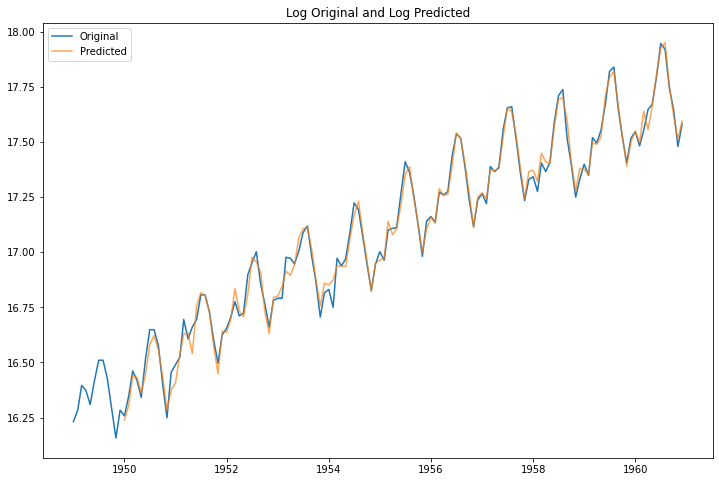

In [65]:
# Overlay our prediction over the actual data to get a sense of how good 
# the model is.

plt.figure(figsize=(12,8))

plt.title('Log Original and Log Predicted')
plt.plot(y_log, label='Original')
plt.plot(pred, alpha=0.7, label='Predicted')

plt.legend()
plt.show()

Below is the results with auto_arima.

In [71]:
# define and fit the model
model = SARIMAX(y_log, order=(2,0,0), seasonal_order=(0, 1, 1, 12), freq='MS')
model_fit_aa = model.fit()

# predict the future!
forecast_aa = model_fit_aa.forecast(24)
pred_aa = model_fit_aa.predict()[12:] # # give it 1 period to create predictions

model_fit_aa.mse

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.54314D+00    |proj g|=  1.79534D+00

At iterate    5    f= -1.67840D+00    |proj g|=  1.41950D+00

At iterate   10    f= -1.68070D+00    |proj g|=  2.30573D-01

At iterate   15    f= -1.68289D+00    |proj g|=  1.29539D+00

At iterate   20    f= -1.68524D+00    |proj g|=  1.89162D-01

At iterate   25    f= -1.69915D+00    |proj g|=  3.86264D-02

At iterate   30    f= -1.69937D+00    |proj g|=  3.01835D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


22.276640238456565

In [72]:
model_fit_aa.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                            #CigSales   No. Observations:                  144
Model:             SARIMAX(2, 0, 0)x(0, 1, [1], 12)   Log Likelihood                 244.710
Date:                              Sat, 22 Oct 2022   AIC                           -481.420
Time:                                      00:08:27   BIC                           -469.888
Sample:                                  01-01-1949   HQIC                          -476.734
                                       - 12-01-1960                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6550      0.069      9.527      0.000       0.520       0.790
ar.L2          0.3368      0.070      4.821      0.000       0.200       0.474
ma.S.L12      -0.5559      0.096     -5.782      0.000      -0.744      -0.367
sigma2         0.0014      0.000      8.686      0.000       0.001       0.002
===================================================================================
Ljung-Box (L1) (Q):                   0.05   Jarque-Bera (JB):                 1.52
Prob(Q):                              0.82   Prob(JB):                         0.47
Heteroskedasticity (H):               0.55   Skew:                             0.06
Prob(H) (two-sided):                  0.05   Kurtosis:                         3.51
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### 3f. Application: Forecasting

We've done well: our model fits pretty closely to our existing data. Let's now use it to forecast what's likely to occur in future.

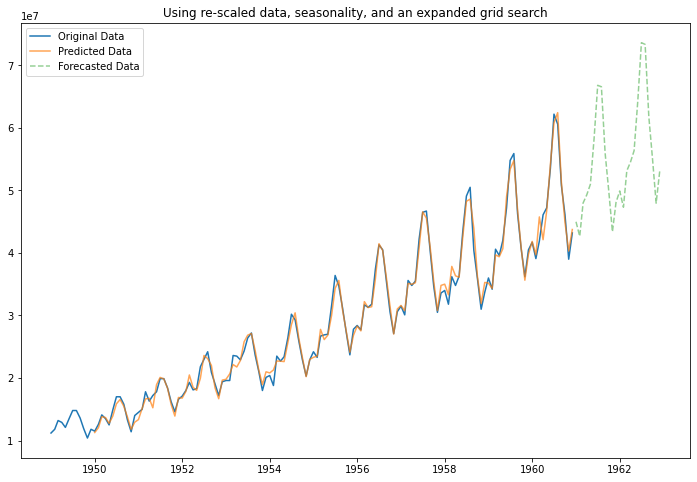

In [73]:
plt.figure(figsize=(12,8))

# plot our original data, with prediction overlay and then project the forecast
plt.title('Using re-scaled data, seasonality, and an expanded grid search')
plt.plot(np.exp(y_log), label='Original Data')
plt.plot(np.exp(pred), alpha=0.7, label='Predicted Data')
plt.plot(np.exp(forecast), label='Forecasted Data', alpha=0.5, ls='--')

plt.legend()
plt.show()

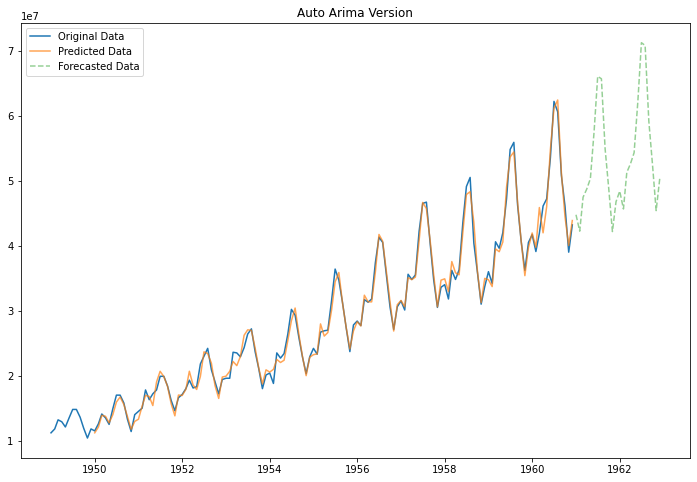

In [75]:
plt.figure(figsize=(12,8))

# plot our original data, with prediction overlay and then project the forecast
plt.title('Auto Arima Version')
plt.plot(np.exp(y_log), label='Original Data')
plt.plot(np.exp(pred_aa), alpha=0.7, label='Predicted Data')
plt.plot(np.exp(forecast_aa), label='Forecasted Data', alpha=0.5, ls='--')

plt.legend()
plt.show()

In [86]:
print(y_log.index)

DatetimeIndex(['1949-01-01', '1949-02-01', '1949-03-01', '1949-04-01',
               '1949-05-01', '1949-06-01', '1949-07-01', '1949-08-01',
               '1949-09-01', '1949-10-01',
               ...
               '1960-03-01', '1960-04-01', '1960-05-01', '1960-06-01',
               '1960-07-01', '1960-08-01', '1960-09-01', '1960-10-01',
               '1960-11-01', '1960-12-01'],
              dtype='datetime64[ns]', name='Month', length=144, freq=None)


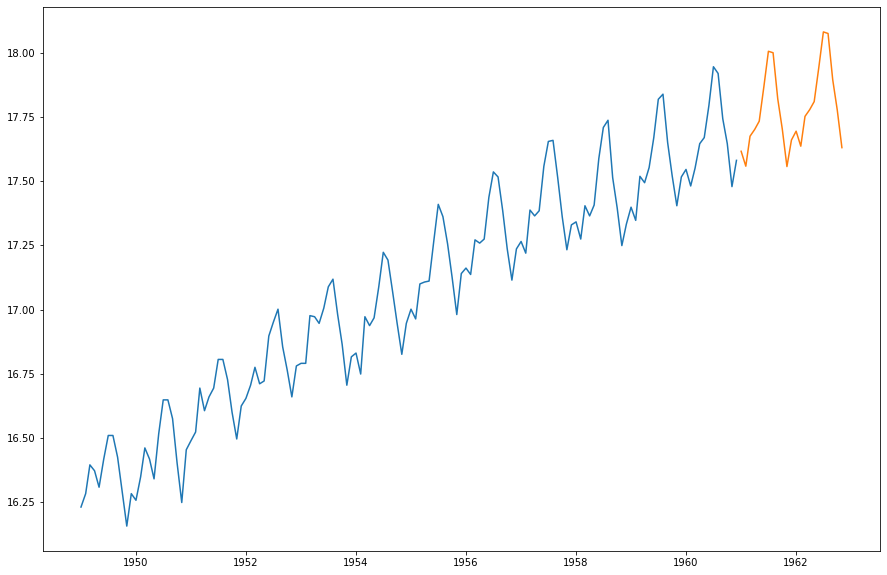

In [110]:
# Declare a variable called forecast_period with the amount of months to forecast, and
# create a range of future dates that is the length of the periods you've chosen to forecast

forecast_period = 24
date_range = pd.date_range(y_log.index[-1], periods = forecast_period, 
              freq='MS').strftime("%Y-%m-%d").tolist()


# Convert that range into a dataframe that includes your predictions
# First, call DataFrame on pd
future_months = pd.DataFrame(date_range, columns = ['Month'])


# Let's now convert the 'Month' column to a datetime object with to_datetime 
future_months['Month'] = pd.to_datetime(future_months['Month'])
future_months.set_index('Month', inplace = True)
future_months['Prediction'] = forecast_aa

# Plot your future predictions
# Call figure() on plt
plt.figure(figsize=(15,10))
plt.plot(y_log)
plt.plot(y_log['Nov 1960'].append(future_months['Prediction']))
plt.show()

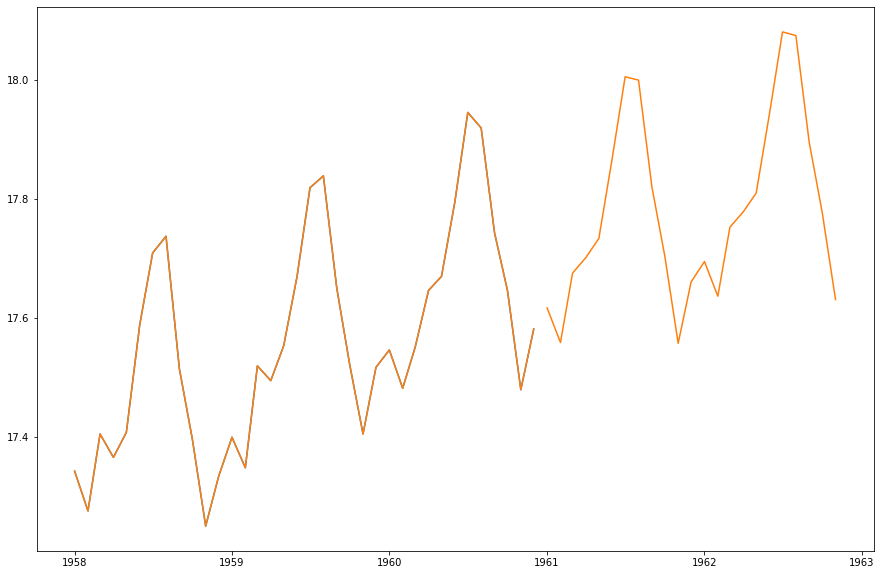

In [111]:
# Now plot the original variable y 
# Use the same functions as before
plt.figure(figsize=(15,10))
plt.plot(y)
plt.plot((y_log['Nov 19.append(future_months['Prediction'])))
plt.show()

## 4. Evaluating and Concluding

Our model captures the centre of a line that's increasing at a remarkable rate. Cowboy Cigarettes sell more cigarettes in the summer, perhaps due to the good weather, disposable income and time off that people enjoy, and the least in the winter, when people might be spending less and enjoying less free time outdoors. 

Remarkably, our ARIMA model made predictions using just one variable. We can only speculate, however, on the causes of the behaviour predicted by our model. We should also take heed that spikes in data, due to sudden unusual circumstances like wars, are not handled well by ARIMA; and the outbreak of the Vietnam War in the 1960s would likely cause our model some distress.  

We could suggest to our employers that, if they are interested in discovering the causes of the cigarette sales trajectory, they execute a regression analysis in addition to the time series one. 

**Credit: During working on this task, I referred to Frank (Peer Mentor)'s python notebook. I am attaching the link below.**

https://github.com/frankfletcher/Springboard-Data-Science/blob/master/Module%2021.1%20-%20Cowboys%20and%20Cigrettes%20Case%20Study/Cowboy%20Cigarettes%20Case%20Study%20-%20Tier%203-FrankFletcher-better-version.ipynb